In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas_ta as ta
from scipy import stats

# ตั้งค่า matplotlib ตามที่ระบุ
font = {'size': 16}
plt.rc('font', **font)

/home/sukrit/miniconda3/envs/trading-analysis/lib/python3.11/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
# ฟังก์ชันตรวจจับ Moonshot
def detect_moonshot(data, window=12, threshold=0.05):
    moonshots = []
    for i in range(len(data) - window):
        if moonshots and (data.index[i] - moonshots[-1]['start_time']).total_seconds() / 3600 < window:
            continue  # ข้ามถ้า Moonshot ใหม่เริ่มภายใน 12 ชั่วโมงจากครั้งก่อน
        close_price = data['close'].iloc[i]
        high_price = data['high'].iloc[i:i+window].max()
        low_price = data['low'].iloc[i:i+window].min()
        moonshot_pct = (high_price - close_price) / close_price
        # เงื่อนไข: ราคาขึ้น >= 5% และ low ไม่ลดเกิน 3%
        if moonshot_pct >= threshold and (low_price - close_price) / close_price > -0.03:
            moonshots.append({
                'start_time': data.index[i],
                'close_price': close_price,
                'high_price': high_price,
                'moonshot_pct': moonshot_pct * 100,
                'window_end_time': data.index[i+window-1]
            })
    return pd.DataFrame(moonshots)

In [3]:
# อ่านข้อมูลจากไฟล์ pickle
data = pd.read_pickle(os.path.abspath("../datasets/processed/1h/BTCUSDT.pkl"))
# ตั้ง index เป็น DatetimeIndex ถ้ายังไม่ได้ตั้ง
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data['time'])
# เลือกคอลัมน์ที่จำเป็น
data = data[['open', 'high', 'low', 'close', 'volume']]

# คำนวณตัวชี้วัด RSI และ MACD
data['rsi'] = ta.rsi(data['close'], length=14)
macd = ta.macd(data['close'], fast=12, slow=26, signal=9)
data['macd'] = macd['MACD_12_26_9']
data['macd_signal'] = macd['MACDs_12_26_9']
data['macd_hist'] = macd['MACDh_12_26_9']

# ตรวจจับ Moonshot
moonshots = detect_moonshot(data, window=12, threshold=0.05)

# หาจุด Peak (เวลาที่ราคา high สูงสุดในหน้าต่าง 12 ชั่วโมง)
moonshots['peak_time'] = moonshots.apply(
    lambda row: data['high'][row['start_time']:row['window_end_time']].idxmax(), axis=1)

# เพิ่มคอลัมน์สำหรับ RSI, MACD, และ Volume ณ จุด Peak
moonshots['rsi_peak'] = moonshots['peak_time'].apply(lambda x: data.loc[x, 'rsi'] if x in data.index else np.nan)
moonshots['macd_peak'] = moonshots['peak_time'].apply(lambda x: data.loc[x, 'macd'] if x in data.index else np.nan)
moonshots['macd_signal_peak'] = moonshots['peak_time'].apply(lambda x: data.loc[x, 'macd_signal'] if x in data.index else np.nan)
moonshots['macd_hist_peak'] = moonshots['peak_time'].apply(lambda x: data.loc[x, 'macd_hist'] if x in data.index else np.nan)
moonshots['volume_peak'] = moonshots['peak_time'].apply(lambda x: data.loc[x, 'volume'] if x in data.index else np.nan)

In [4]:
# 1. สรุปสถิติของ RSI, MACD, และ Volume ณ จุด Peak
print("Summary of Indicators at Moonshot Peak (5% in 12 Hours):")
indicators = ['rsi_peak', 'macd_peak', 'macd_signal_peak', 'macd_hist_peak', 'volume_peak']
for indicator in indicators:
    print(f"\n{indicator.replace('_peak', '').upper()}:")
    my_stats = {
        'Count': moonshots[indicator].count(),
        'Mean': moonshots[indicator].mean(),
        'Std': moonshots[indicator].std(),
        'Min': moonshots[indicator].min(),
        'Max': moonshots[indicator].max(),
        'Median': moonshots[indicator].median(),
        '25th Percentile': moonshots[indicator].quantile(0.25),
        '75th Percentile': moonshots[indicator].quantile(0.75)
    }
    for key, value in my_stats.items():
        print(f"{key}: {value:.2f}")

Summary of Indicators at Moonshot Peak (5% in 12 Hours):

RSI:
Count: 634.00
Mean: 66.78
Std: 12.80
Min: 14.09
Max: 95.85
Median: 68.29
25th Percentile: 57.86
75th Percentile: 76.19

MACD:
Count: 634.00
Mean: 142.35
Std: 333.51
Min: -1492.43
Max: 2042.77
Median: 91.55
25th Percentile: 4.29
75th Percentile: 267.62

MACD_SIGNAL:
Count: 634.00
Mean: 41.42
Std: 329.88
Min: -1860.66
Max: 1725.63
Median: 43.82
25th Percentile: -48.99
75th Percentile: 163.49

MACD_HIST:
Count: 634.00
Mean: 100.93
Std: 115.69
Min: -352.24
Max: 680.17
Median: 58.76
25th Percentile: 24.77
75th Percentile: 154.91

VOLUME:
Count: 634.00
Mean: 7142.47
Std: 8900.62
Min: 14.48
Max: 80041.75
Median: 4733.74
25th Percentile: 2092.09
75th Percentile: 8736.35


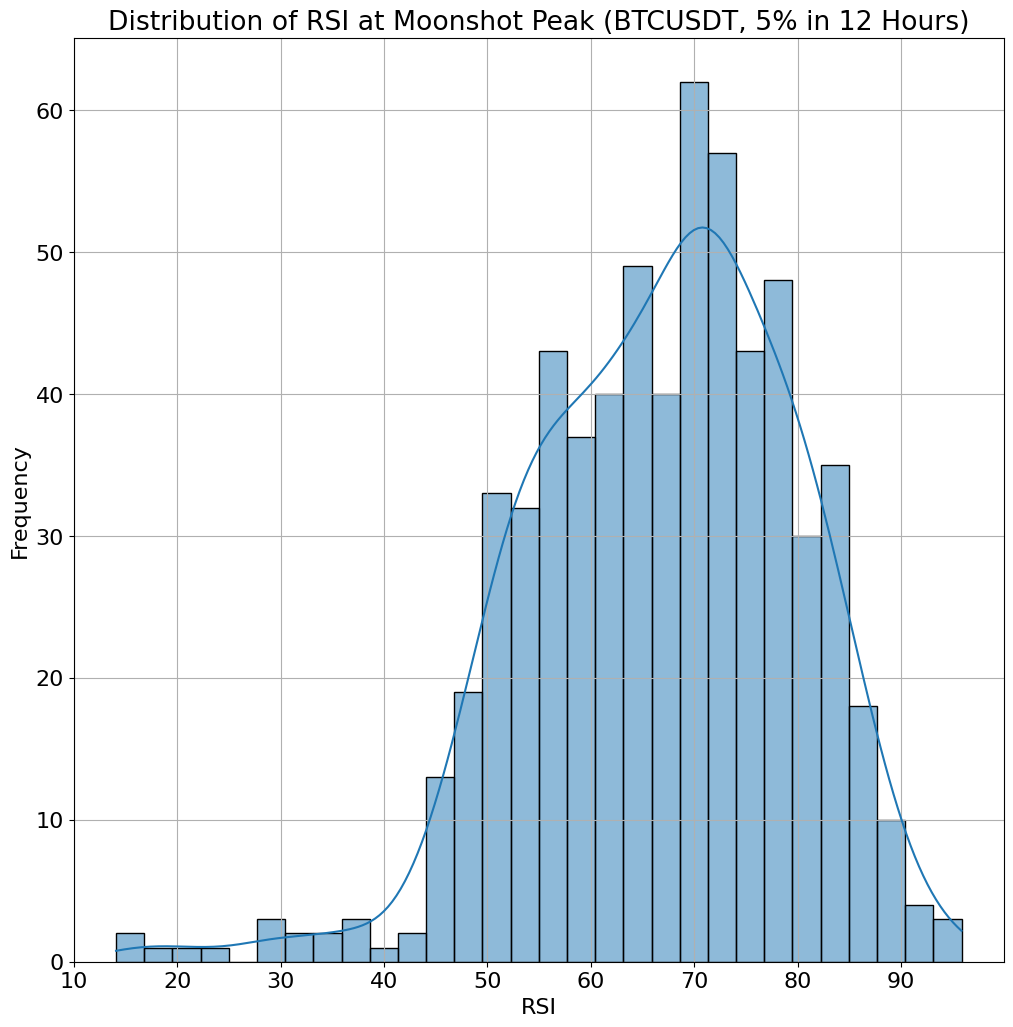

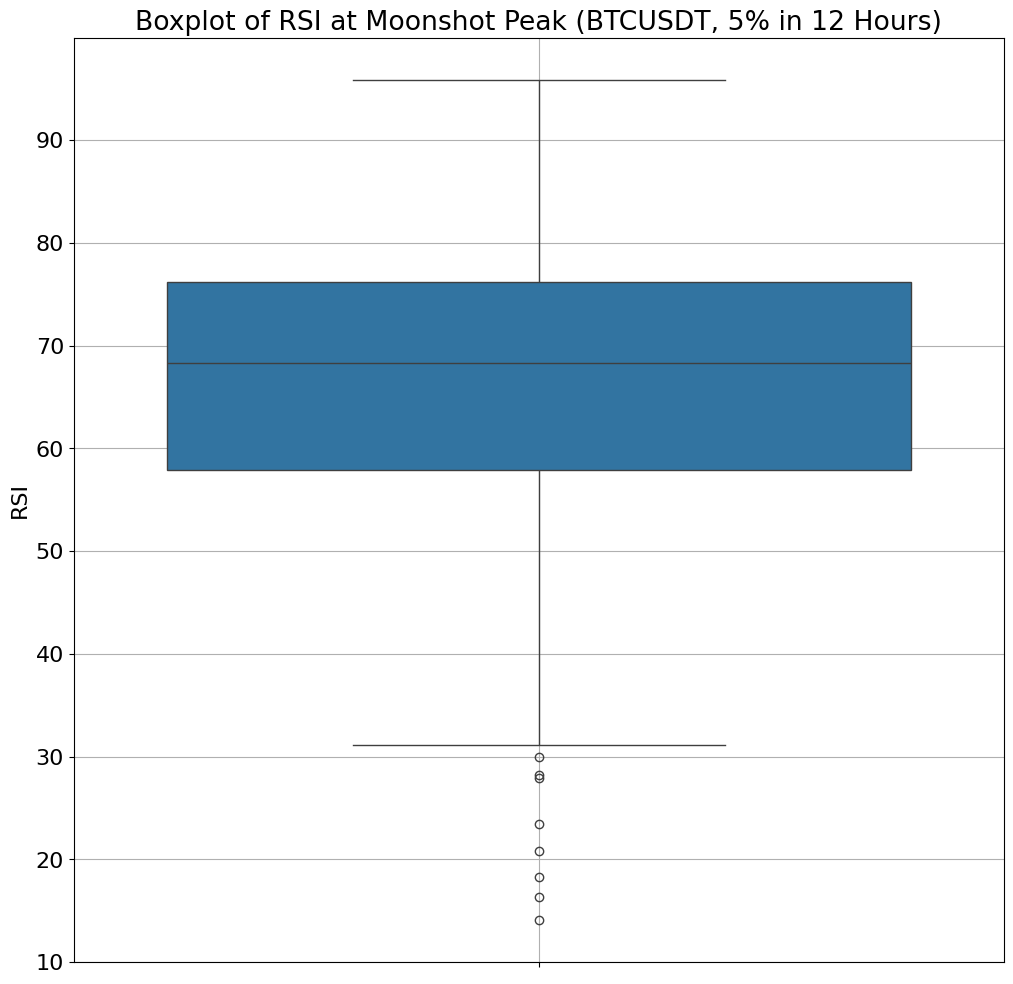

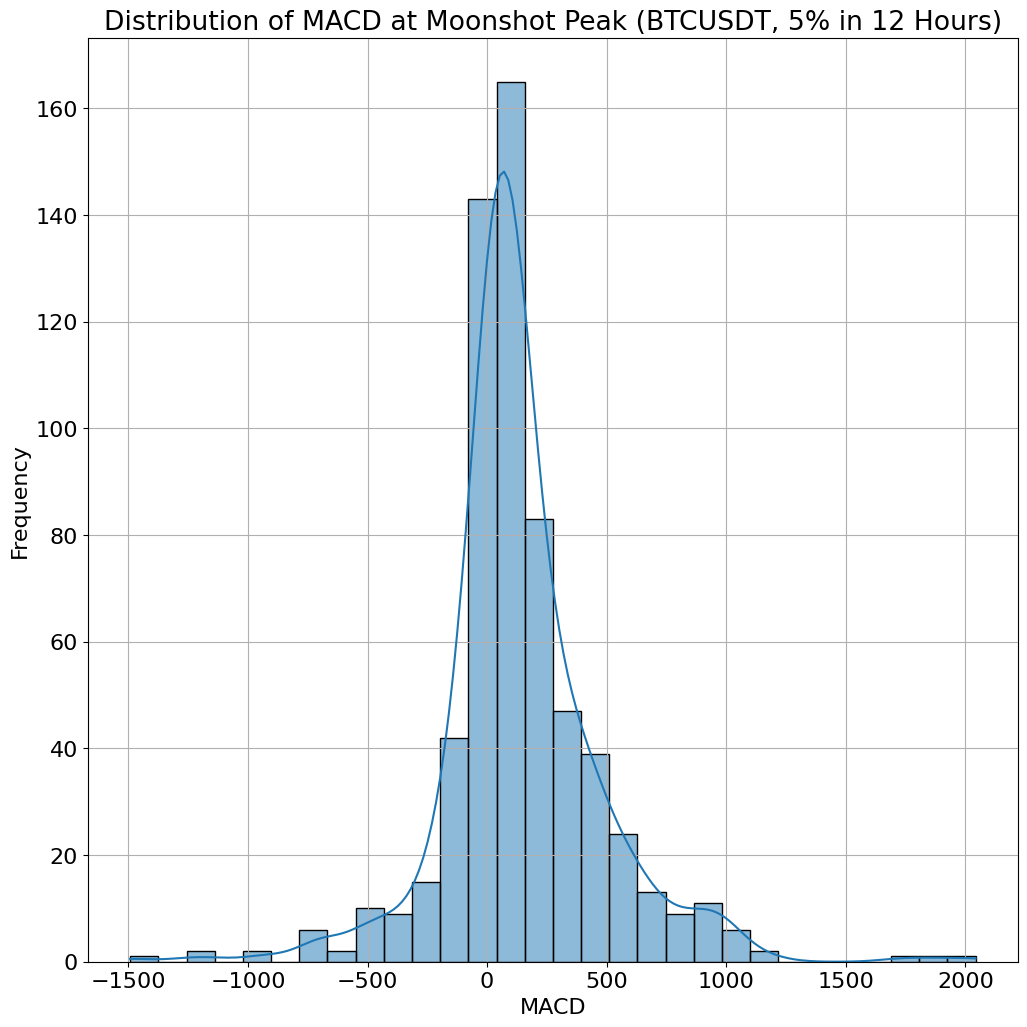

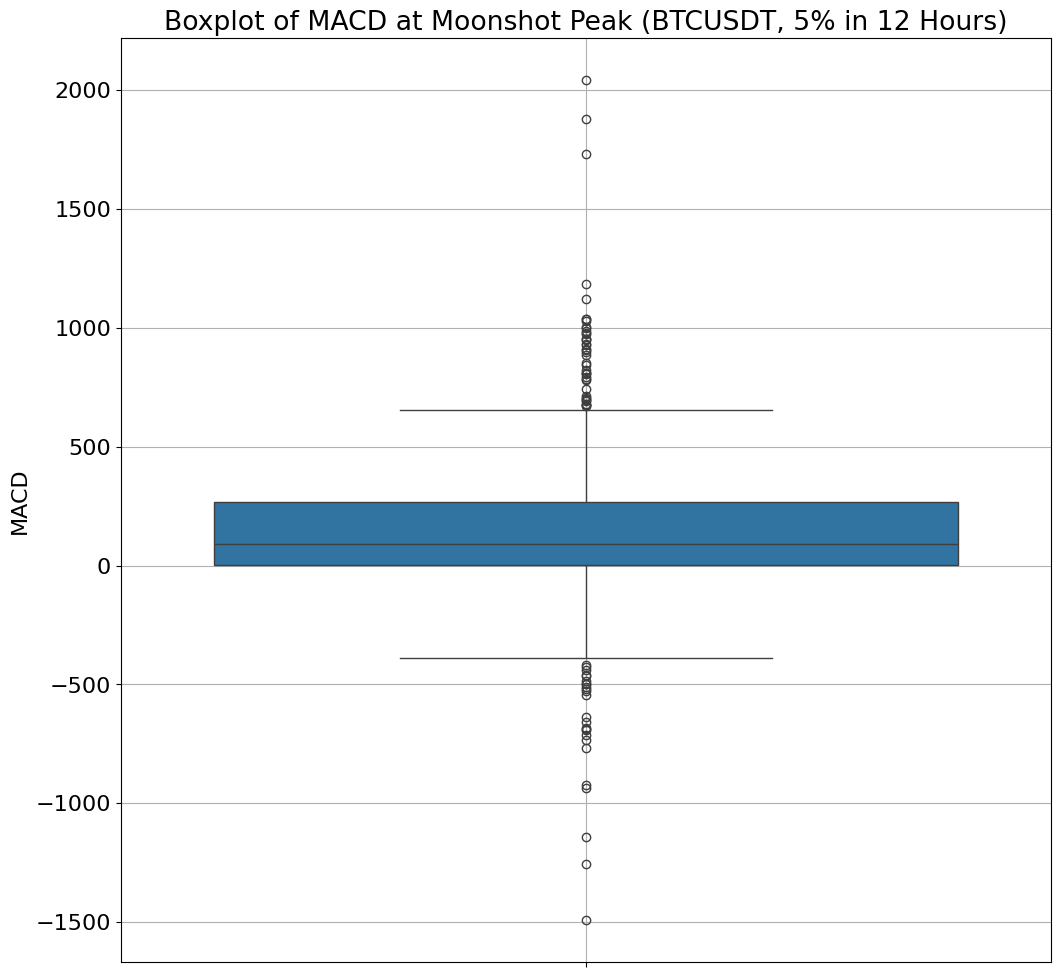

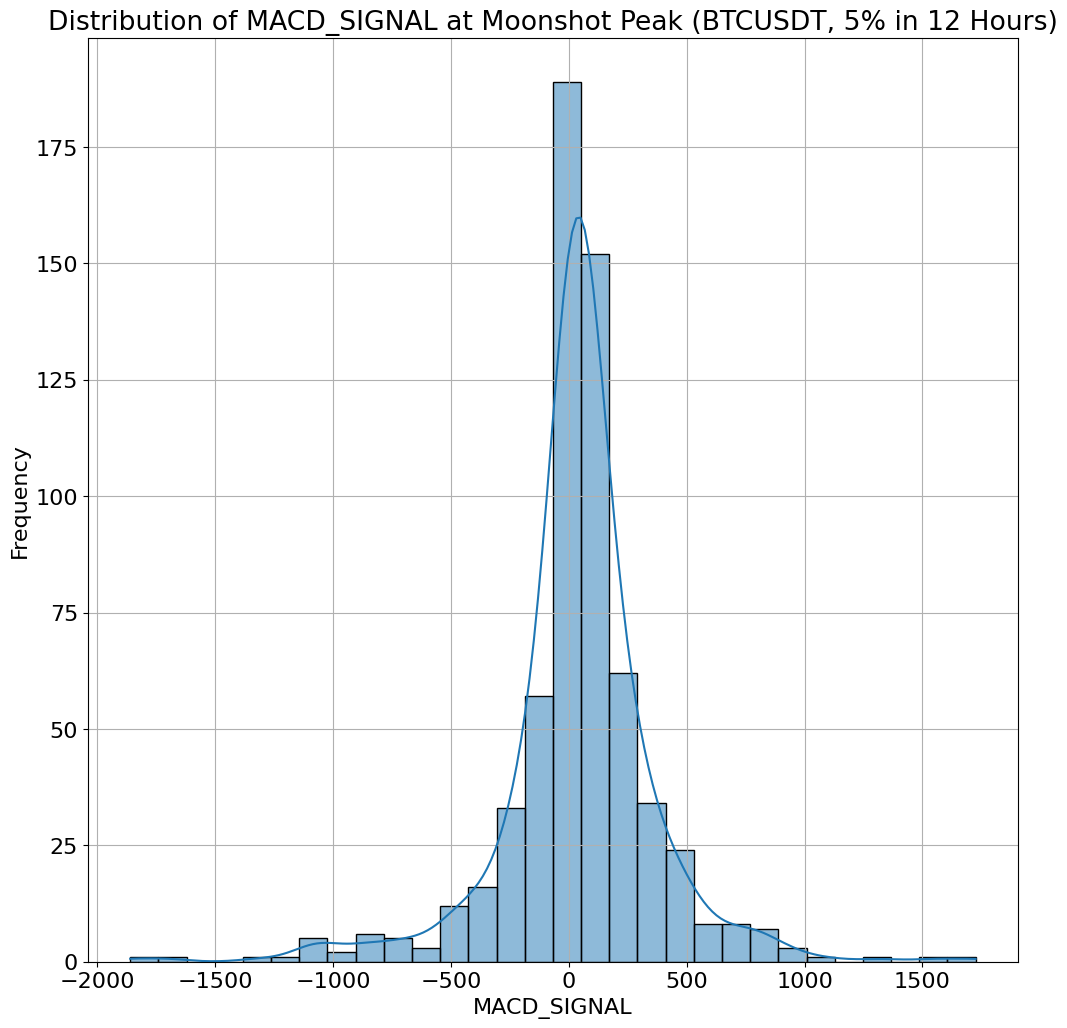

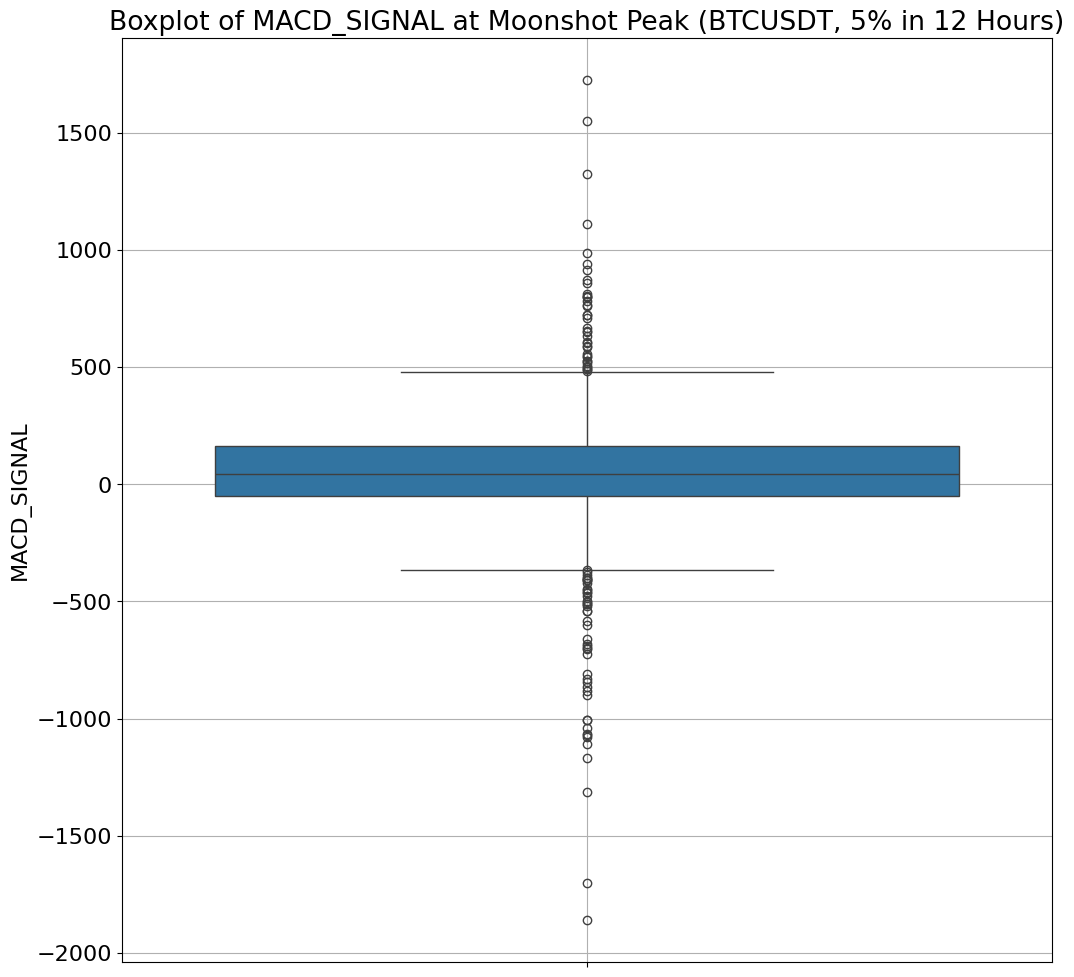

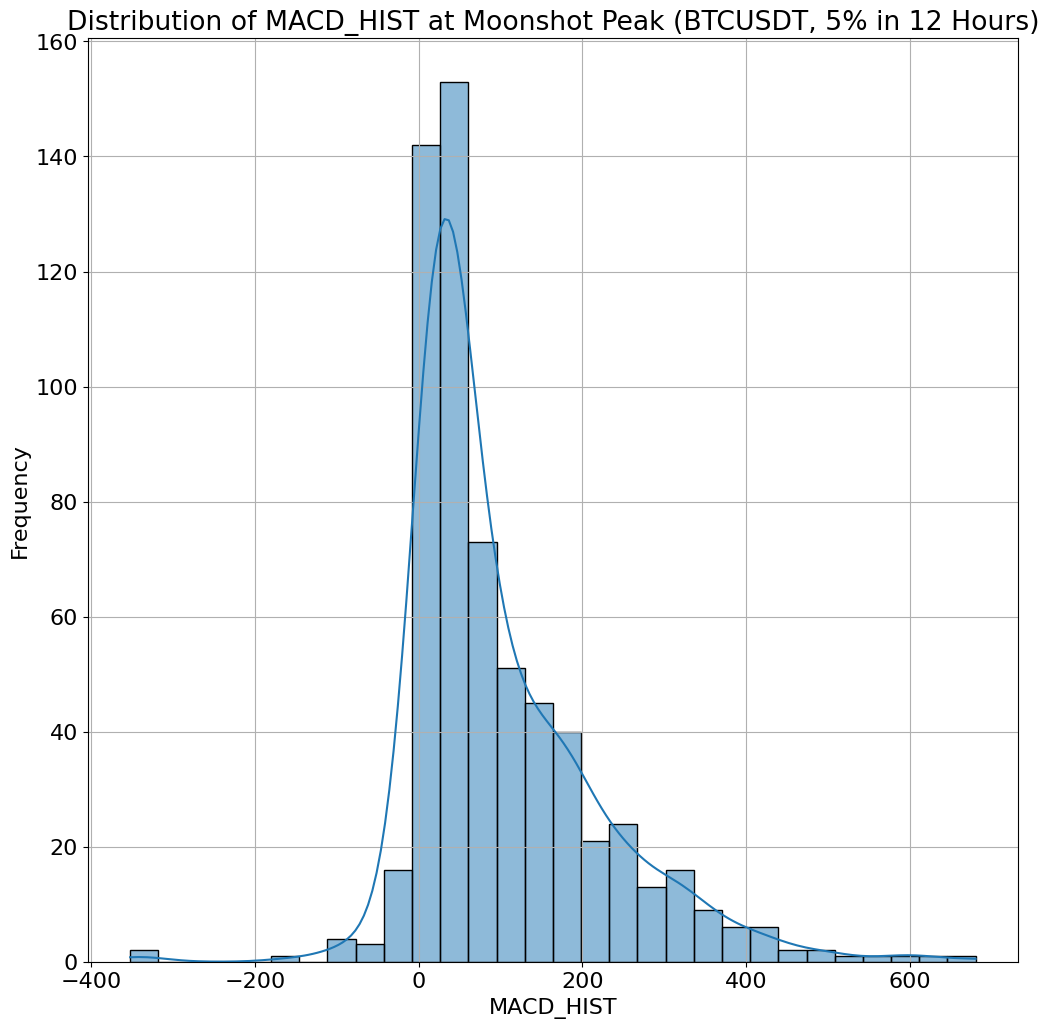

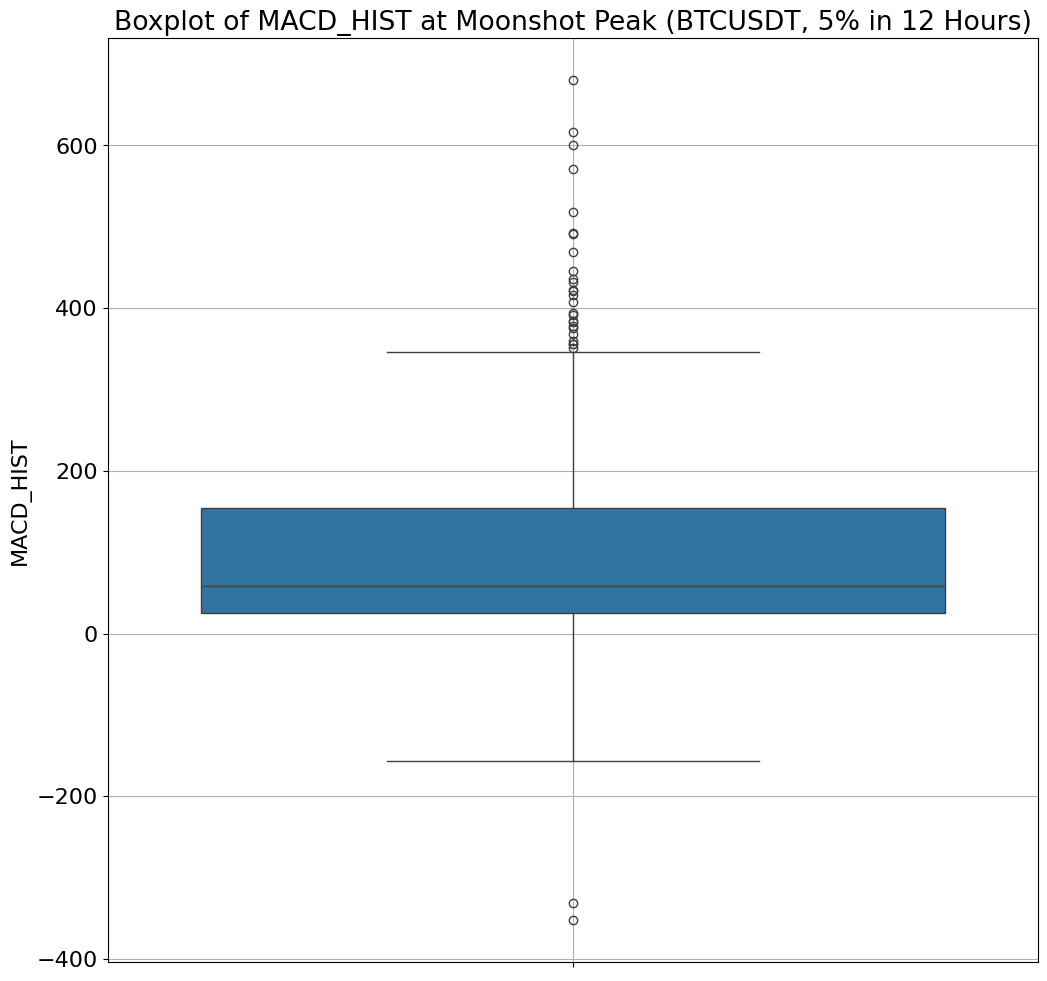

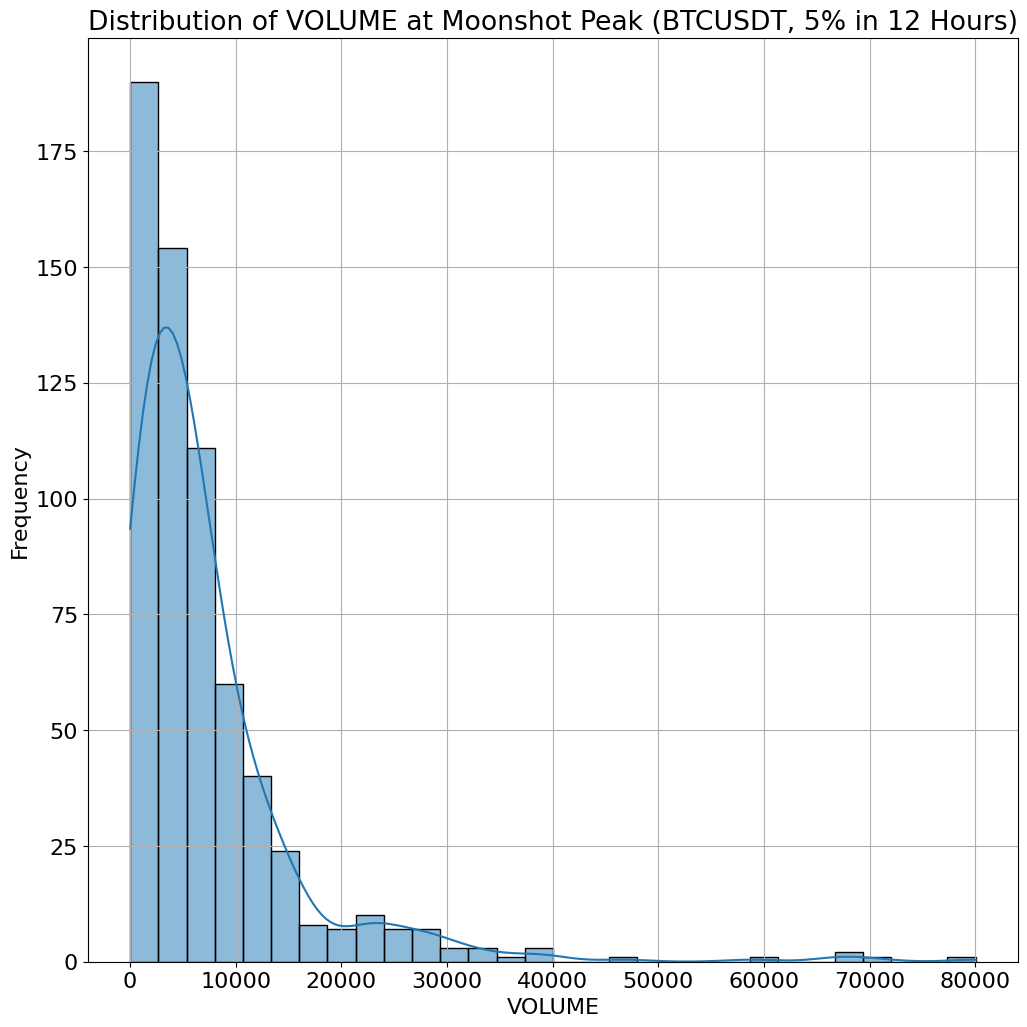

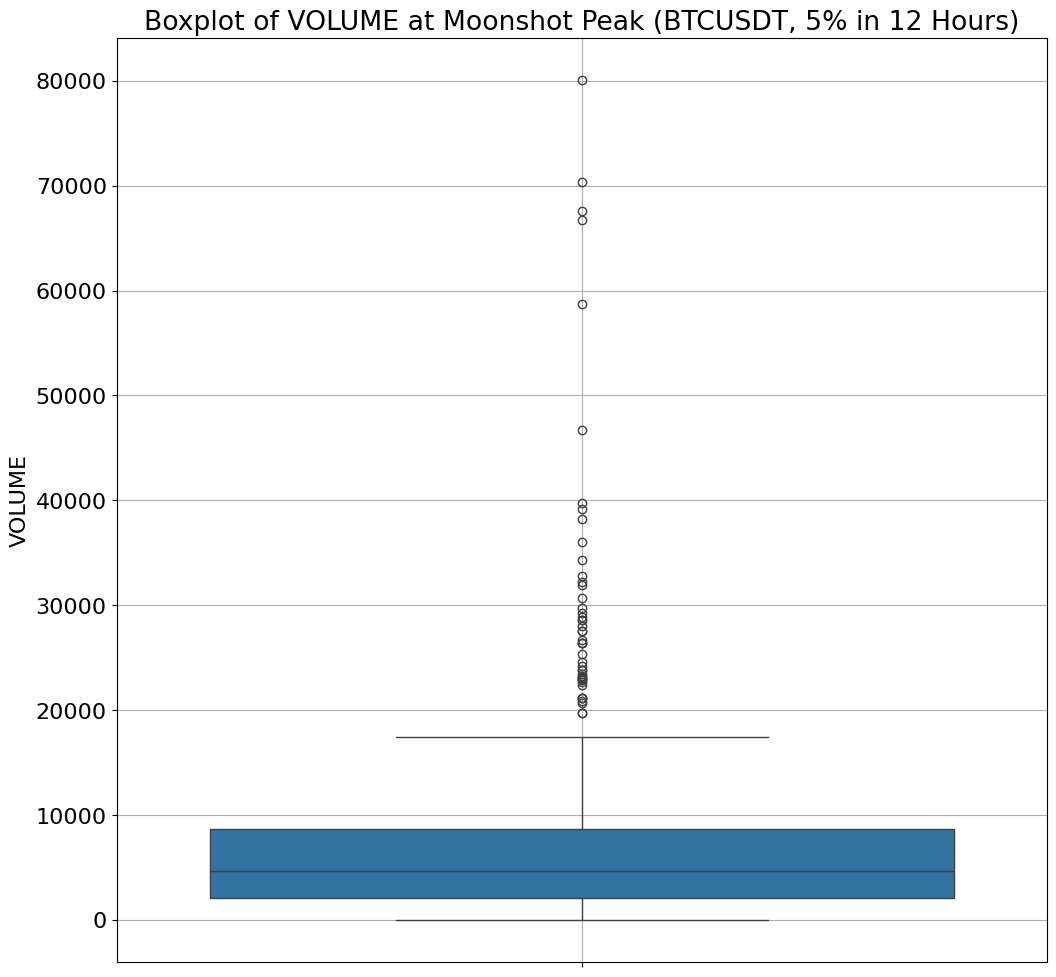

In [5]:
# 2. สร้าง Histogram และ Boxplot สำหรับแต่ละตัวชี้วัด
for indicator in indicators:
    # Histogram
    plt.figure(figsize=(12, 12))
    sns.histplot(moonshots[indicator].dropna(), bins=30, kde=True)
    plt.title(f'Distribution of {indicator.replace("_peak", "").upper()} at Moonshot Peak (BTCUSDT, 5% in 12 Hours)')
    plt.xlabel(indicator.replace('_peak', '').upper())
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Boxplot
    plt.figure(figsize=(12, 12))
    sns.boxplot(y=moonshots[indicator].dropna())
    plt.title(f'Boxplot of {indicator.replace("_peak", "").upper()} at Moonshot Peak (BTCUSDT, 5% in 12 Hours)')
    plt.ylabel(indicator.replace('_peak', '').upper())
    plt.grid(True)
    plt.show()

In [6]:
# 3. ทดสอบความปกติของการแจกแจง
for indicator in indicators:
    stat, p_value = stats.shapiro(moonshots[indicator].dropna().sample(min(5000, len(moonshots[indicator].dropna()))))
    print(f"\nShapiro-Wilk Test for {indicator.replace('_peak', '').upper()}:")
    print(f"stat={stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("The distribution is not normal (p < 0.05)")
    else:
        print("The distribution is normal (p >= 0.05)")


Shapiro-Wilk Test for RSI:
stat=0.9773, p-value=0.0000
The distribution is not normal (p < 0.05)

Shapiro-Wilk Test for MACD:
stat=0.8988, p-value=0.0000
The distribution is not normal (p < 0.05)

Shapiro-Wilk Test for MACD_SIGNAL:
stat=0.8744, p-value=0.0000
The distribution is not normal (p < 0.05)

Shapiro-Wilk Test for MACD_HIST:
stat=0.8577, p-value=0.0000
The distribution is not normal (p < 0.05)

Shapiro-Wilk Test for VOLUME:
stat=0.6631, p-value=0.0000
The distribution is not normal (p < 0.05)
